In [1]:
%load_ext autoreload
%autoreload 2

# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


import sys


sys.path.append("../PFN4CASHPlus/")
sys.path.append("../Analysis/Priors/")

from data_gen.synth_ablation import get_batch_func as synth_get_batch_func

No GPU -> using CPU: cpu


In [2]:
import lcpfn

Curved = lcpfn.LCPFN(
    model_name="../Analysis/PFN/trained_models/curved.pt"
)
Semi_Flat = lcpfn.LCPFN(
    model_name="../Analysis/PFN/trained_models/semi-flat.pt"
)

Flat = lcpfn.LCPFN(
    model_name="../Analysis/PFN/trained_models/flat.pt"
)

models = {
    "Curved": Curved,
    "Semi-Flat": Semi_Flat,
    "Flat": Flat,
}
colors = {
    "Curved": "tab:orange",
    "Semi-Flat": "tab:green",
    "Flat": "tab:blue",
}

<Figure size 640x480 with 0 Axes>

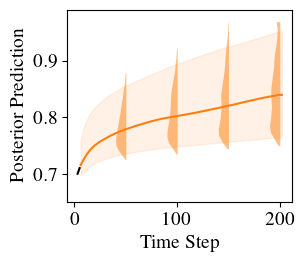

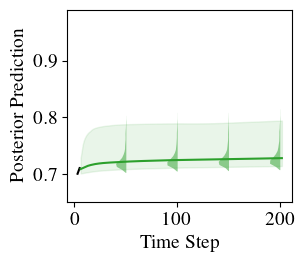

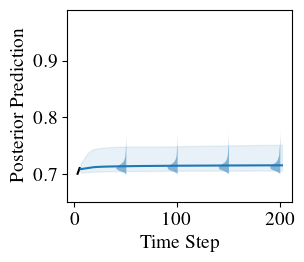

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

import matplotlib as mpl

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
        "axes.labelsize": 14,
        "font.size": 14,
    }
)


seq_len = 200
init = 3
xs = np.arange(init, init + seq_len).reshape((seq_len, 1))
ys = np.asarray([0.7, 0.705, 0.71]).reshape((-1, 1))
cutoff = len(ys) 
xs = torch.from_numpy(xs.astype(np.float32))
ys = torch.from_numpy(ys.astype(np.float32))
fig = plt.figure()

for i, (model_name, model_obj) in enumerate(models.items()):
    # --- Main Plot: Line Plot ---
    plt.figure(figsize=(2.9, 2.5))

    plt.plot(
        xs[:cutoff, 0].cpu().numpy(), ys[:, 0].cpu().numpy(), "black", label="Context"
    )
    points = (
        (
            model_obj.model.criterion.borders[:-1]
            + model_obj.model.criterion.bucket_widths / 2
        )
        .detach()
        .cpu()
        .numpy()
    )
    predictions = model_obj.predict_mean(
        x_train=xs[:cutoff].to(device),
        y_train=ys.to(device),
        x_test=xs[cutoff:].to(device),
    )

    logits = model_obj(
        x_train=xs[:cutoff].to(device),
        y_train=ys.to(device),
        x_test=xs[cutoff:].to(device),
    )[:, 0, :, 0]
    probs = F.softmax(logits, dim=-1).detach().cpu().numpy()

    records = []
    time_idxes = [50, 100, 150, 200]
    for time_idx in time_idxes:
        for value_idx in range(probs.shape[1]):
            count = int(
                probs[time_idx - init - 1, value_idx] * 1000
            )  # scale for density
            records.extend([(time_idx, points[value_idx])] * count)

    df = pd.DataFrame(records, columns=["x", "value"])

    # plt.plot(
    #     xs[cutoff:],
    #     predictions[:, 0].cpu(),
    #     colors[model_name],
    #     label=f"Extrapolation Mean by {model_name}",
    # )
    predictions = model_obj.predict_quantiles(
        x_train=xs[:cutoff].to(device),
        y_train=ys.to(device),
        x_test=xs[cutoff:].to(device),
        qs=[0.05, 0.5, 0.95],
    )

    plt.plot(
        xs[cutoff:].numpy(),
        predictions[:, 1, 0].cpu().numpy(),
        colors[model_name],
        label=f"{model_name}",
    )
    for time_idx in time_idxes:
        violin = plt.violinplot(
            df.value[df.x == time_idx].to_numpy(),
            positions=[time_idx],
            widths=20,
            showmedians=False,
            showextrema=False,
            side="low",
            quantiles=None,
            bw_method=0.1,
            points=20,
        )

        for pc in violin["bodies"]:
            pc.set_facecolor(colors[model_name])  # Safe access to `colors`
            pc.set_edgecolor(colors[model_name])  # Set the color of the edge lines
            pc.set_linewidth(0)
            pc.set_alpha(0.5)

    plt.fill_between(
        xs[cutoff:].flatten(),
        predictions[:, 0, 0].cpu(),
        predictions[:, 2, 0].cpu(),
        color=colors[model_name],
        alpha=0.1,
        label="CI of 95%",
    )

    # Cutoff line
    # plt.axvline(
    #     xs[cutoff, 0].numpy(), color="k", linestyle="--", linewidth=0.8, label="Cutoff"
    # )
    # ax_main.legend(loc="lower right")
    # plt.legend(loc="upper left")
    plt.ylabel("Posterior Prediction")
    plt.xlabel("Time Step")
    plt.ylim(0.65, 0.99)
    plt.savefig(
        "./figures/3_types_priors_" + str(model_name) + ".pdf",
        bbox_inches="tight",
        dpi=600,
    )